# ROB 538 Multiagent Systems

Multiagent distance-constrained orienteering(?) solved with **Multiagent Evolutionary Reinforcement Learning (MERL)**

SETUP: Clone our environment and MERL repository to colab files

In [1]:
!git clone https://github.com/natbut/rob538_merl.git
# !git clone https://github.com/ta-wells/rob538_merl.git
%cd rob538_merl

# Check if requirements.txt exists and install dependencies
import os

if os.path.exists('requirements.txt'):
    !pip install -r requirements.txt
else:
    print("requirements.txt not found.")

Cloning into 'rob538_merl'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 235 (delta 94), reused 144 (delta 57), pack-reused 47 (from 1)
Receiving objects: 100% (235/235), 44.17 MiB | 19.07 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/rob538_merl


SETUP: Mount drive (if needed)

In [2]:
from google.colab import drive
# drive.mount('/content/drive')

# Example: Save results to Google Drive
# !cp output.txt /content/drive/MyDrive/


SETUP: GPU Toggle

In [3]:
GPU = False

SETUP: Import MERL policy and training files


In [4]:
import time
import numpy as np
import yaml
import copy
import math

from control.mothership import gen_mother_from_config
from control.passenger import generate_passengers_from_config
from control.task import generate_tasks_from_config
from env.environment import make_environment_from_config, Environment
from utils.visualizer import set_up_visualizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque

## **Set Up Policy and Training Functions**

POLICY: Define Multi-head Policy functions

In [5]:
class MultiHeadedPolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_actions, num_agents):
        """
        Initializes a multi-headed policy network.

        Args:
            input_dim (int): The size of the input observation (M).
            hidden_dim (int): The number of units in the hidden layers.
            num_actions (int): The number of possible actions (N).
            num_agents (int): The number of agents (K).
        """
        super(MultiHeadedPolicyNetwork, self).__init__()
        self.trunk = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Create separate heads for each agent
        self.heads = nn.ModuleList([nn.Linear(hidden_dim, num_actions) for _ in range(num_agents)])

    def forward(self, input):
        """
        Forward pass through the network.

        Args:
            input (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            list[torch.Tensor]: A list of tensors, each of shape (batch_size, num_actions),
                                representing action probability distributions for each agent.
        """
        # Pass the input through the shared backbone
        trunk_output = self.trunk(input)

        # Generate action probabilities for each agent using separate heads
        outputs = []
        for head in self.heads:
            head_output = head(trunk_output)
            action_probs = head_output

            # === FOR NORMALIZING ===
            # # Ensure non-negative values by subtracting the minimum
            # head_output = head_output - head_output.min()

            # # Calculate the sum of the tensor elements
            # total_sum = head_output.sum()

            # # Normalize to make the values sum to 1.0
            # if total_sum > 0:  # Avoid division by zero
            #     action_probs = head_output / total_sum
            # else:
            #     # Handle edge case where the sum is 0 (all values in head_output are identical)
            #     action_probs = torch.full_like(head_output, fill_value=1.0 / head_output.numel())

            # === or FOR SOFTMAX ===
            # action_probs = F.softmax(head_output, dim=-1)

            outputs.append(action_probs)

        return outputs

    def get_action(self, observation):
        """Get actions for all agents given an observation."""
        with torch.no_grad():
            # Put observation on GPU, query network
            if GPU:
              observation = observation.cuda().float().unsqueeze(0)
              action_distributions = self.forward(observation.cuda().float())
            else:
              observation = observation.float().unsqueeze(0)
              action_distributions = self.forward(observation.float())
            # Samples actions from distributions
            actions = [torch.argmax(probs).item() for probs in action_distributions]

        return actions


class Policy:

    def __init__(self, observation_size, hidden_dim, num_agents, action_dict, agent_velocity) -> None:

        self.fitness = None
        self.reward = None
        self.dense_reward = None
        self.action_dict = action_dict
        self.num_agents = num_agents
        self.agent_velocity = agent_velocity
        # Define policy network and mount to GPU
        if GPU:
          self.policy_net = MultiHeadedPolicyNetwork(observation_size,
                                                   hidden_dim,
                                                   len(action_dict),
                                                   num_agents).cuda()
        else:
          self.policy_net = MultiHeadedPolicyNetwork(observation_size,
                                                   hidden_dim,
                                                   len(action_dict),
                                                   num_agents)

    def get_action(self, observation):
        """
        8 Discrete Actions (perhaps):
        [1,0], [1,1], [0,1], [-1,1], [-1,0], [-1,-1], [0,-1], [1,-1]
        """
        if GPU:
          obs_tensor = torch.tensor(np.array(observation)).cuda().float()
        else:
          obs_tensor = torch.tensor(np.array(observation)).float()
        obs_tensor = obs_tensor.flatten() # prepare network input

        joint = self.policy_net.get_action(obs_tensor) # query network

        return joint

    def process_action(self, joint_action_ids):
        """
        Convert action ids to velocity vectors
        """
        actions_with_vel = []
        for action_id in joint_action_ids:
            # process output action id's into robots joint motions
            action = np.multiply(self.action_dict[action_id],
                                   self.agent_velocity)
            actions_with_vel.append(action)

        return actions_with_vel


def epsilon_greedy_action(policy: Policy, state, epsilon, num_agents, num_actions):
  """Take epsilon greedy action"""

  rand_val = np.random.random()
  joint_ids = []
  if rand_val < epsilon:
    # Take explorative action
    for i in range(num_agents):
      act_id = np.random.randint(num_actions)
      joint_ids.append(act_id)
  else:
    # Take greedy action
    joint_ids = policy.get_action(state)
    # print("GREEDY ACTIONS:", joint_ids)
  return joint_ids

EA: Define EA crossover, mutation, selection, etc. functions

In [6]:
def crossover(parent1: Policy, parent2: Policy):
    """Perform crossover between two networks."""
    child = copy.deepcopy(parent1)
    child.fitness = None
    child.reward = None
    child.dense_reward = None
    for param1, param2 in zip(child.policy_net.parameters(), parent2.policy_net.parameters()):
        mask = torch.rand_like(param1) < 0.5
        param1.data[mask] = param2.data[mask]
    return child

def mutate(network: Policy, mutation_rate=0.1):
    """Mutate a network by adding noise to its parameters."""
    for param in network.policy_net.parameters():
        if torch.rand(1).item() < mutation_rate:
            noise = torch.randn_like(param) * 0.1
            param.data.add_(noise)

def tournament_selection(population: list[Policy], tournament_size=3):
    """
    Select one individual using tournament selection. Randomly pick `tournament_size` individuals and select the one with the highest fitness.
    """
    policies = np.random.choice(population, tournament_size)
    best = max(policies, key=lambda pol: pol.fitness)
    return best

REWARDS: Define reward and PBRS functions

In [7]:
def compute_global_reward(env: Environment, passenger_list):
    """
    Compute global reward as sum of completed tasks.
    """
    task_reward = sum(t.complete for t in env.task_dict.values())
    comms_reward = sum(p.connected_to_M for p in passenger_list)

    return task_reward+comms_reward


def compute_dense_local_reward(env: Environment,passenger_list,distance_scalar=100000):
    """
    L(s) = 1/(dist to nearest_incomplete_task) * comm_i

    Gain some reward for moving closer to an incomplete task, but gain no reward if we have lost connection.
    """


    reward_list = []
    incomplete_list = []
    connected = 0
    for task in env.task_dict.values():
      if not task.complete:
        incomplete_list.append(task)

    #Iterate over all passengers
    for p in passenger_list:
      #Check if we have connected to the mothership
      if p.connected_to_M:
        connected = 1
      else:
        connected = 0

      #Get agent position
      a_loc = env.agent_loc_dict[p.id]
      b_loc = env.base_loc
      d_base = np.linalg.norm(np.round(np.subtract(b_loc, a_loc),1)[:2])

      #Find distance to closest incomplete task
      for n,task_incomp in enumerate(incomplete_list):

        #Calculate Distance
        d_rel = np.linalg.norm(np.round(np.subtract(task.location, a_loc),1)[:2])

        #If first calc, set to min
        if n == 0:
          d_task_min = d_rel

        #if less, set new minimum
        if d_rel < d_task_min:
          d_task_min = d_rel

      #Find distance to closest CONNECTED agent or BASE, reward accordingly
      d_agent_min = 1000000
      for p_2 in passenger_list:
        if not p_2.connected_to_M:
            continue

        #Get agent position
        other_loc = env.agent_loc_dict[p_2.id]

        #Find Relative position
        d_agent = np.linalg.norm(np.round(np.subtract(other_loc, a_loc),1)[:2])

        if d_agent_min == 0:
            d_agent_min = d_agent

        #Ignore if equal to current agent
        if not math.isclose(d_agent,0,abs_tol=1e-3):
          #Check if first time

          if d_agent < d_agent_min:
            d_agent_min = d_agent

        # If not near any connected agents, use distance to base
        if d_agent_min == 1000000:
          other_loc = env.agent_loc_dict[-1]

          #Find Relative position
          d_agent_min = np.linalg.norm(np.round(np.subtract(other_loc, a_loc),1)[:2])


      #Now calculate reward and append to list)
      dist = 15000
      # L_i = np.exp(-((d_agent_min - dist) ** 2) / (2 * 3000 ** 2)) # L1
      L_i = (1/np.exp(d_task_min/distance_scalar))*connected # L2

      reward_list.append(L_i)

    return reward_list


def compute_potential(env: Environment):
    """
    Compute a global potential function for the current environment state
    """
    # Let's try average distance to nearest incomplete task for each agent
    inv_dists_to_nearest_task = []

    for a in env.agent_loc_dict:
        if a == -1: # skip mothership
            continue

        min_dist = np.inf
        for t in env.task_dict.values():
            dist = np.linalg.norm(env.agent_loc_dict[a] - t.location)
            if dist < min_dist:
                min_dist = dist

        # Append inverse because we want to provide positive reward when min_dist value goes down
        inv_dists_to_nearest_task.append(1/min_dist)

    return np.mean(inv_dists_to_nearest_task)


TRAINING: Define RL functions

In [8]:
import random
import torch.optim as optim
from copy import deepcopy

def do_exploring(env,
                 mothership,
                 passenger_list,
                 pol,
                 replay_buffer,
                 epsilon,
                 comms_max_range,
                 timeout,
                 num_agents,
                 num_actions,
                 ):
  """Add explorative experiences to replay buffer using epsilon-greedy"""

  # Add some explorative experiences to replay buffer here (maybe 10%-25% of buffer)
  num_RL_experiences = len(replay_buffer)/5 # REPLACE 20% of buffer with RL actions (adds some exploration!)
  count = 0
  while count < num_RL_experiences:

    # Reset tasks and agent locs
    env.reset()

    # Reset agents
    mothership.reset(env)
    for p in passenger_list:
        p.reset(env)

    # Run Simulation
    done = False
    step = 0

    # !!! Startup for RL
    # Update state
    for p in passenger_list:
        # Update observations
        p.update_state(env, comms_max_range)
    for p in passenger_list:
        p.check_neighbor_connect(env, comms_max_range)

    # Update global observation (same as local)
    mothership.update_observation(env, step)
    # Use policy to get next joint action
    state = mothership.observation[:]

    while not done and step < timeout:
        step += 1

        # Get joint action using epsilon-greedy
        joint_action_ids = epsilon_greedy_action(pol, state, epsilon, num_agents, num_actions)
        joint_action = pol.process_action(joint_action_ids)

        # Update environment
        done = env.step(joint_action, passenger_list)
        reward = compute_dense_local_reward(env, passenger_list)

        # Update state
        for p in passenger_list:
            # Update observations
            p.update_state(env, comms_max_range)
        for p in passenger_list:
            p.check_neighbor_connect(env, comms_max_range)
        # Update global observation (same as local)
        mothership.update_observation(env, step)
        # Use policy to get next joint action
        new_state = mothership.observation[:]

        # RL: Add observations, actions, rewards to replay buffer for RL
        replay_buffer.append((state, joint_action_ids, reward, new_state, done))
        count += 1

        # Update state
        state = new_state


def train_RL_offline(env,
                      mothership,
                      passenger_list,
                      pol,
                      target_net,
                      optimizer,
                      replay_buffer,
                      batch_size,
                      lr,
                      gamma,
                      ):
  """
  Train network (DQN) over a batch of simulation experiences from replay buffer using RL
  """

  if len(replay_buffer) < batch_size:
    return [0]

  minibatch = random.sample(replay_buffer, batch_size)
  losses_tracker = []
  losses = []
  #====================================================

  for state, action, reward, next_state, done in minibatch:
    # print("Experience: State=", state, "Action=", action, "Reward=", reward, "Next=", next_state, "Done=", done)
    losses = []
    verbose = False
    # if 100 in reward:
    #   verbose = True

    if verbose:
      print("\nTraining Experience:\n\tState:", state, "\n\tAction:", action, "\n\tReward:", reward, "\n\tNext State:", next_state )

    for a_id, head in enumerate(pol.policy_net.heads):
      if verbose:
        print("\tDoing head", a_id)
      #Init Optimizer per head
      optimizer = optim.Adam(head.parameters(), lr=lr)

      state_act_vals = pol.policy_net(torch.tensor(state, dtype=torch.float32))
      next_state_act_vals = pol.policy_net(torch.tensor(next_state, dtype=torch.float32))
      if verbose:
        print("State Action Vals for head:", state_act_vals[a_id])
        print("Next State Action Vals for head:", next_state_act_vals[a_id])

      target = reward[a_id]
      if not done:
        # TODO might need to change where softmax is applied for action outputs
        target = reward[a_id] + gamma * torch.max(next_state_act_vals[a_id]).item()

      if verbose:
        print("Action", action[a_id], "| Reward:", reward[a_id], " | Target:", target)

      target_f = deepcopy(state_act_vals[a_id].detach().numpy())
      target_f[action[a_id]] = target

      if verbose:
        print("Head act vals with target:", target_f, " Head init act vals:", state_act_vals[a_id])

      optimizer.zero_grad()
      loss = nn.MSELoss()(torch.tensor(target_f), pol.policy_net(torch.tensor(state, dtype=torch.float32))[a_id])
      if verbose:
        print("Computed loss:", loss)
      loss.backward()
      optimizer.step()

      if verbose:
        print("!! Updated State-Act Vals:", pol.policy_net(torch.tensor(state, dtype=torch.float32))[a_id])

      losses.append(loss.item())
    losses_tracker.append(losses)
  #============================================

  return losses_tracker




In [9]:
from utils.visualizer import *
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

def visualize_policy(policy: Policy,
                     test_config,
                      topo_file,
                      tide_folder,
                     scaling
                     ):
    """Visualize policy rollout"""

    # Load testing params
    with open(test_config, "r") as f:
        config = yaml.safe_load(f)
        verbose = config["verbose"]
        timeout = config["sim_timeout"]
        comms_max_range = config["comms_max_range"]
        random_base = config["random_base"]
        base_loc = config["base_loc"]

    f.close()

    # print("Initializing...")

    # === Initialize ===

    # Initialize environment
    # print("\t Environment...")
    env = make_environment_from_config(test_config,
                                       topo_file,
                                       tide_folder
                                       )
    # Generate tasks & base
    env.task_dict = generate_tasks_from_config(test_config, env)
    env.setup_base_loc(random_base, base_loc)

    # Initialize agents
    # print("\t Agents...")
    passenger_list = generate_passengers_from_config(test_config)
    mothership = gen_mother_from_config(test_config, passenger_list)
    mothership.agent_ids = [a.id for a in passenger_list]
    mothership.passenger_list = passenger_list
    for p in passenger_list:
        p.agent_ids = [a.id for a in passenger_list]
        p.passenger_list = passenger_list
        p.mothership_id = mothership.id

    # === Evaluate Policy (Rollout) ===

    # Reset tasks and agent locs
    # if verbose: print("\t Reset Env & Agents")
    env.reset()

    # Reset agents
    mothership.reset(env)
    for p in passenger_list:
        p.reset(env)

    # Run Simulation
    done = False
    step = 0
    # if verbose: print("\t Start Sim")

    # Update state
    for p in passenger_list:
        # Update observations
        p.update_state(env, comms_max_range)
    for p in passenger_list:
        p.check_neighbor_connect(env, comms_max_range)
    # Update global observation (same as local)
    mothership.update_observation(env, 0.0, scaling)
    # Use policy to get next joint action
    state = mothership.observation[:]

    cum_dense_rew = 0
    stored_agent_locations = []

    while not done and step < timeout:
        step += 1

        joint_action_ids = policy.get_action(state)
        joint_action = policy.process_action(joint_action_ids)

        # Update environment
        # (NOTE Try out different reward shaping approaches here)
        done = env.step(joint_action, passenger_list)
        reward = compute_dense_local_reward(env, passenger_list)
        cum_dense_rew += np.average(reward)

        # Update state
        for p in passenger_list:
            # Update observations
            p.update_state(env, comms_max_range)
        for p in passenger_list:
            p.check_neighbor_connect(env, comms_max_range)
        # Update global observation (same as local)
        mothership.update_observation(env, step/timeout, scaling)
        new_state = mothership.observation[:]

        # Update state
        state = new_state

        locations = [loc for loc in env.agent_loc_dict.values()]
        if len(stored_agent_locations) < timeout:
            stored_agent_locations.append(deepcopy(locations))

    # Calculate final global reward
    final_reward = compute_global_reward(env, passenger_list)

    print("\t Sim Complete. Dense Reward Sum:", cum_dense_rew, " | Global Reward:", final_reward)

    # ==== Plot agent trajectories and task locations ===

    # Create a colormap for gradient coloring
    cmap = plt.cm.viridis  # Change to other colormaps if preferred (e.g., 'plasma', 'coolwarm')
    norm = Normalize(vmin=0, vmax=len(stored_agent_locations) - 1)

    viz = set_up_visualizer(env, env.task_dict, title="Policy Trajectory")
    viz._prepare_plot()
    viz._add_tasks_to_plot()
    # Generate unique base colors for each agent
    num_agents = len(stored_agent_locations[0])
    base_colors = plt.cm.tab10(np.linspace(0, 1, num_agents))  # Adjust colormap as needed

    # Normalize time steps for gradient mapping
    norm = Normalize(vmin=0, vmax=len(stored_agent_locations) - 1)

    for rob_id in range(num_agents):
        rob_x = []
        rob_y = []
        rob_z = []

        for t, locs in enumerate(stored_agent_locations):
            rob_loc = locs[rob_id]
            rob_x.append(rob_loc[0])
            rob_y.append(rob_loc[1])
            rob_z.append(rob_loc[2])

        # Create a monochromatic colormap for this agent
        base_color = base_colors[rob_id]
        agent_cmap = LinearSegmentedColormap.from_list(f"agent_{rob_id}_cmap", ["white", base_color])

        # Generate gradient colors based on time
        gradient_colors = agent_cmap(norm(range(len(stored_agent_locations))))

        if env.SLICE:
            # 2D case
            for i in range(1, len(rob_x)):
                viz.ax.scatter(
                    rob_x[i - 1:i + 1],
                    rob_y[i - 1:i + 1],
                    color=gradient_colors[i],
                    alpha=0.8,
                )
        else:
            # 3D case
            for i in range(1, len(rob_x)):
                viz.ax.scatter(
                    rob_x[i - 1:i + 1],
                    rob_y[i - 1:i + 1],
                    rob_z[i - 1:i + 1],
                    color=gradient_colors[i],
                    alpha=0.8,
                )
    plt.show()

TRAINING: Define train function with EA & RL components

In [10]:
from utils.visualizer import *
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

def train_MERL(test_config,
          topo_file,
          tide_folder,
          USE_EA = True,
          USE_RL = True,
          ) -> Policy:
    """
    Execute training loop.


    Returns best-performing policy and training data
    """

    # Load testing params
    with open(test_config, "r") as f:
        config = yaml.safe_load(f)
        verbose = config["verbose"]
        num_agents = config["num_robots"]
        num_tasks = config["problem_size"]
        agent_vel = config["velocity"]
        epochs = config["epochs"]
        tests = config["tests"]
        timeout = config["sim_timeout"]
        num_policies = config["num_policies"]
        show_viz = config["viz"]
        comms_max_range = config["comms_max_range"]
        random_base = config["random_base"]
        base_loc = config["base_loc"]
        hidden_dim = config["hidden_dim"]
        obs_size = 1+3*num_agents #(num_agents + num_tasks) # time step + (x,y) relative pos of agents+base and tasks + task status
        potentials = config["potentials"]
        buffer_size = config["buffer_size"]
        batch_size = config["batch_size"]
        alpha = config["alpha"] # lr
        gamma = config["gamma"]
        epsilon = config["epsilon"]
    f.close()


    print("Initializing...")

    # ====== TESTING ======= .01 .9
    epochs = 100 #change to 100 later
    timeout=50
    #print(epsilon)
    #print(alpha)
    #print(gamma)
    #epsilon = 1
    buffer_size = 100000
    batch_size = 2000
    alpha = 0.00002
    # gamma = .95
    #eps_decay_rate = .02
    eps_decay_rate = epsilon/epochs

    # === Initialize ===

    # Initialize results logging
    global_rewards_over_training = []
    average_loss_over_training = []
    average_cum_dense_rew_over_training = []

    # Initialize environment
    print("\t Environment...")
    env = make_environment_from_config(test_config,
                                       topo_file,
                                       tide_folder
                                       )
    # Generate tasks & base
    env.task_dict = generate_tasks_from_config(test_config, env)
    env.setup_base_loc(random_base, base_loc)
    # print([task.location for task in env.task_dict.values()])
    # print(env.base_loc)

    # Initialize agents
    print("\t Agents...")
    passenger_list = generate_passengers_from_config(test_config)
    mothership = gen_mother_from_config(test_config, passenger_list)
    mothership.agent_ids = [a.id for a in passenger_list]
    mothership.passenger_list = passenger_list
    for p in passenger_list:
        p.agent_ids = [a.id for a in passenger_list]
        p.passenger_list = passenger_list
        p.mothership_id = mothership.id

    # Initialize a population of k policies
    print("\t Policies...")
    action_dict ={0: [1,0,0],
                1: [1,1,0],
                2: [0,1,0],
                3: [-1,1,0],
                4: [-1,0,0],
                5: [-1,-1,0],
                6: [0,-1,0],
                7: [1,-1,0],
                }
    if USE_EA:
      policies = [Policy(obs_size, hidden_dim, num_agents, action_dict, agent_vel) for _ in range(num_policies)]
    else:
      policies = [Policy(obs_size, hidden_dim, num_agents, action_dict, agent_vel)]

    #Initialize target network???
    target_net = Policy(obs_size, hidden_dim, num_agents, action_dict, agent_vel)
    #Init Optimizer???
    optimizer = [None for _ in range(len(policies[0].policy_net.heads))] #for _ in range(len(policies))]

    # for pol_id, pol in enumerate(policies):
    #   for head_id,head in enumerate(pol.policy_net.heads):
    #     optimizer[pol_id][head_id] = optim.Adam(head.parameters(), lr=alpha) # optim.AdamW(head.parameters(), lr=alpha, amsgrad=True)

    # REPLAY BUFFER
    replay_buffer = deque(maxlen=buffer_size)

    print("Begin Training")
    for ep in range(epochs):

        # High-level evolution loop
        if verbose: print("\n==== Trial", ep, " ====")

        # === Evaluate Policies (Rollout) ===

        # Loop through each unevaluated policy. All agents use pol to get action values
        for pol in policies:
            if USE_EA and pol.fitness != None:
                continue

            tests_final_rewards = [] # track final rewards from multiple tests
            tests_rewards_with_potentials = [] # track G+F from multiple tests
            aggr_potential = 0
            prev_state_potential = 0

            # Rollout policy in multiple randomized environments
            tests_cum_dense_rews = []
            for ts in range(tests):

                if verbose: print("\t == Test ", ts, " ==")

                # Reset tasks and agent locs
                if verbose: print("\t Reset Env & Agents")
                env.reset()

                # Reset agents
                mothership.reset(env)
                for p in passenger_list:
                    p.reset(env)

                # Start Visualizer
                if show_viz:
                    title = "Tr " + str(ep) + ", Ts", str(ts)
                    viz = set_up_visualizer(env, env.task_dict, title)

                # Run Simulation
                done = False
                step = 0
                if verbose: print("\t Start Sim")

                # !!! Startup for RL
                # Update state
                for p in passenger_list:
                    # Update observations
                    p.update_state(env, comms_max_range)
                for p in passenger_list:
                    p.check_neighbor_connect(env, comms_max_range)
                # Update global observation (same as local)
                mothership.update_observation(env, 0.0)
                # Use policy to get next joint action
                state = mothership.observation[:]

                cum_dense_rew = 0

                while not done and step < timeout:
                    step += 1

                    # Get joint action
                    if not USE_EA:
                        # Do exploring if using only RL
                        joint_action_ids = epsilon_greedy_action(pol,
                                                                 state,
                                                                 epsilon,
                                                                 num_agents,
                                                                 len(action_dict))
                    else:
                        # Otherwise use greedy action
                        joint_action_ids = pol.get_action(state)
                    joint_action = pol.process_action(joint_action_ids)

                    # Update environment
                    # (NOTE Try out different reward shaping approaches here)
                    done = env.step(joint_action, passenger_list)
                    reward = compute_dense_local_reward(env, passenger_list)
                    cum_dense_rew += np.average(reward)

                    # Update state
                    for p in passenger_list:
                        # Update observations
                        p.update_state(env, comms_max_range)
                    for p in passenger_list:
                        p.check_neighbor_connect(env, comms_max_range)
                    # Update global observation (same as local)
                    mothership.update_observation(env, step/timeout)
                    # Use policy to get next joint action
                    new_state = mothership.observation[:]

                    # Calculate new state potential(s) here for PBRS
                    if potentials:
                        state_potential = compute_potential(env)
                        aggr_potential += (state_potential-prev_state_potential) # P(s')-P(s)
                        prev_state_potential = state_potential

                    # RL: Add observations, actions, rewards to replay buffer for RL
                    replay_buffer.append((state, joint_action_ids, reward, new_state, done))

                    # Update state
                    state = new_state

                    # Opt. update visual
                    if show_viz:
                        viz.display_env(passenger_list + [mothership], static=False)
                        time.sleep(0.05)

                if show_viz:
                    viz.close_viz()

                # Calculate final global reward with PBRS, add it to reward tracker
                final_reward = compute_global_reward(env, passenger_list)
                tests_final_rewards.append(final_reward)
                tests_rewards_with_potentials.append(final_reward + aggr_potential) # Use G+F, with F=sum(P(s')-P(s))
                tests_cum_dense_rews.append(cum_dense_rew) # Store accumulated dense reward for tests
                if verbose: print("\t Sim Complete. Reward:", final_reward)

            # Evaluate fitness as average G+F over rollouts, assign to policy
            pol.fitness = np.mean(tests_rewards_with_potentials) # Fitness = G+F
            pol.reward = np.mean(tests_final_rewards)
            pol.dense_reward = np.mean(tests_cum_dense_rews)
            if verbose: print("Policy fitness:", pol.fitness)

        # Select population of policies to retain (top half)
        policies.sort(key=lambda policy: policy.fitness, reverse=True)
        global_rewards_over_training.append(policies[0].reward)
        print("Gen", ep, "Policies Fitness: ", [p.fitness for p in policies], " | Best Dense Reward:", policies[0].dense_reward)
        sorted_by_dense = sorted(policies, key=lambda policy: policy.dense_reward, reverse=True)
        average_cum_dense_rew_over_training.append(sorted_by_dense[0].dense_reward)
        best_policy = policies[0]

        if ep != epochs-1:
          rl_policy = deepcopy(policies[0])
          rl_policy.fitness = None
          rl_policy.reward = None
          rl_policy.dense_reward = None
          target_net.policy_net.load_state_dict(rl_policy.policy_net.state_dict())
          for head_id,head in enumerate(rl_policy.policy_net.heads):
              optimizer[head_id] = optim.Adam(head.parameters(), lr=alpha)

        # print("CURRENT BEST")
        # visualize_policy(policies[0], test_config, topo_file, tide_folder, scaling=False)

        # ==== PERIODICALLY ==== TODO RL: Do some RL using a buffer of experiences
        if USE_EA and USE_RL:
          # If we are using EA, then we need to fill buffer with some exploratory experiences
          do_exploring(env,
                      mothership,
                      passenger_list,
                      pol,
                      replay_buffer,
                      epsilon,
                      comms_max_range,
                      timeout,
                      num_agents,
                      len(action_dict),
                       )

        if USE_RL:
            training_loss_hist = train_RL_offline(env,
                                                  mothership,
                                                  passenger_list,
                                                  rl_policy,
                                                  target_net,
                                                  optimizer,
                                                  replay_buffer,
                                                  batch_size,
                                                  alpha,
                                                  gamma,
                                                  )

            average_loss_over_training.append(np.mean(training_loss_hist))

            # print("AFTER RL")
            # visualize_policy(rl_policy, test_config, topo_file, tide_folder, scaling=False)

        # Decay epsilon throughout training
        #epsilon = epsilon*(1-eps_decay_rate)
        epsilon = epsilon - eps_decay_rate

        if not USE_EA:
            policies[0] = rl_policy

        # Break early (no new children) if not using EA or in last cycle
        if ep == epochs-1 or not USE_EA:
            continue

        # === EA STUFF BELOW ===
        new_policies = [policies[0], rl_policy] # keep best policy + rl policy
        # Mutate & crossover to make new policies, flag as unevaluated
        mutation_rate = 0.5
        mut_decay = 0.5/num_policies
        while len(new_policies) < num_policies:
            parent1 = tournament_selection(policies, num_policies//3)
            parent2 = tournament_selection(policies, num_policies//3)
            child = crossover(parent1, parent2)
            mutate(child, mutation_rate)
            new_policies.append(child)
            mutation_rate -= mut_decay
        policies = new_policies[:]


    # Return best policy and logged info
    # best_policy = max(policies, key=lambda policy: policy.reward)
    print("Returning policy with reward:", best_policy.reward)

    return best_policy, global_rewards_over_training, average_cum_dense_rew_over_training, average_loss_over_training



## **Execute Training**

Define training parameters

In [11]:
test_config = "config/baseline_config.yaml"
topo_file = "datasets/topogrophy/topography.nc"
tide_folder = "datasets/currents"

Execute training

Initializing...
	 Environment...
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Agents...
	 Policies...
Begin Training
Gen 0 Policies Fitness:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 6.505892927592017
CURRENT BEST
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Sim Complete. Dense Reward Sum: 6.505892927592016  | Global Reward: 1


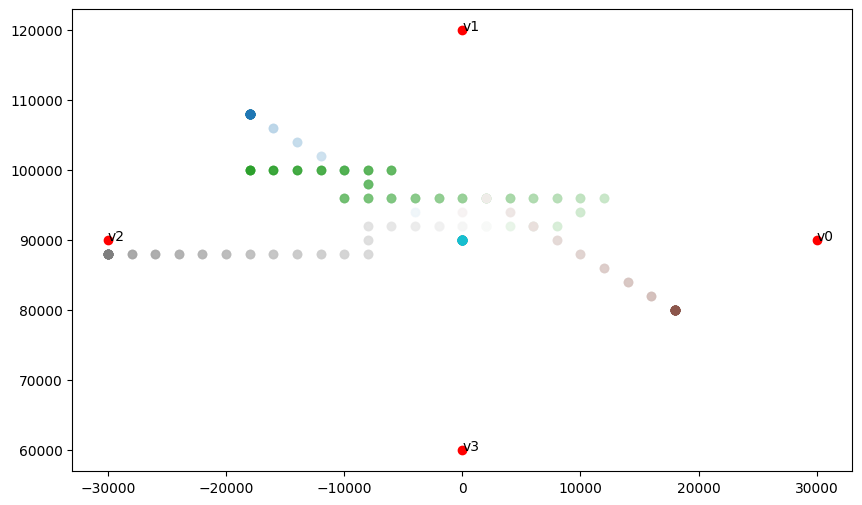

AFTER RL
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Sim Complete. Dense Reward Sum: 5.724970008831356  | Global Reward: 0


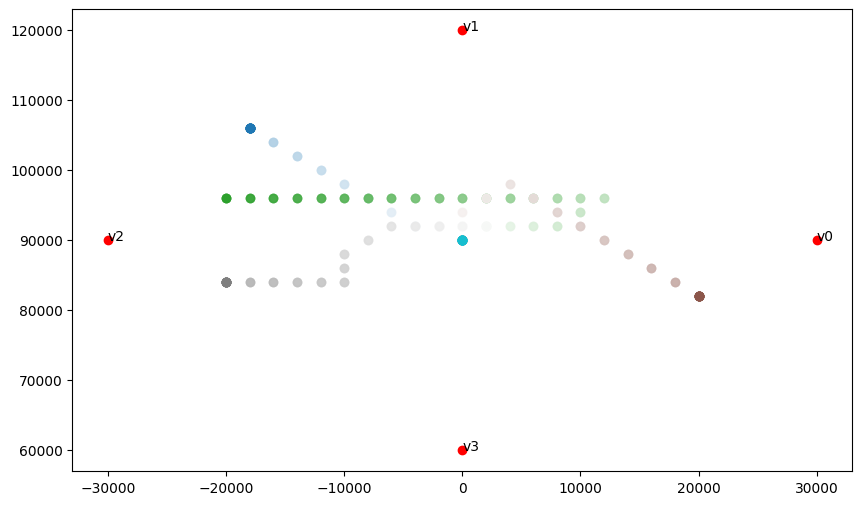

Gen 1 Policies Fitness:  [2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 5.0333065064596525
CURRENT BEST
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Sim Complete. Dense Reward Sum: 5.0333065064596525  | Global Reward: 2


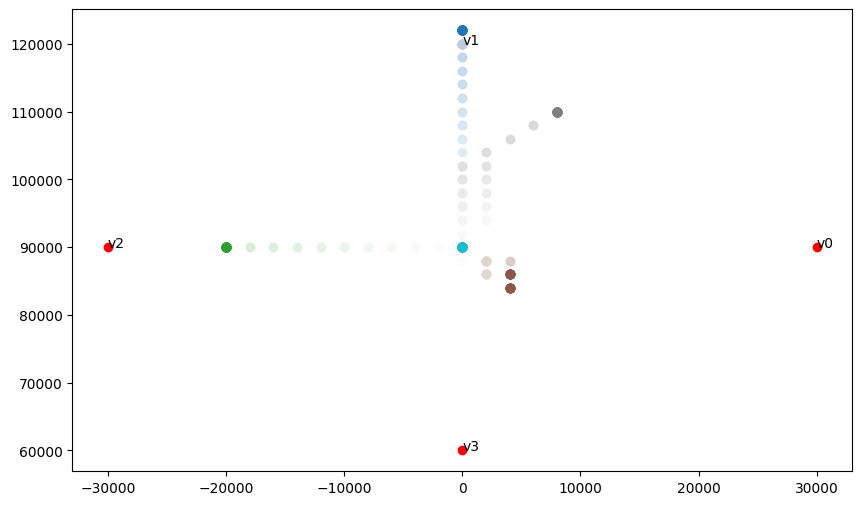

AFTER RL
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Sim Complete. Dense Reward Sum: 2.9817456610440924  | Global Reward: 1


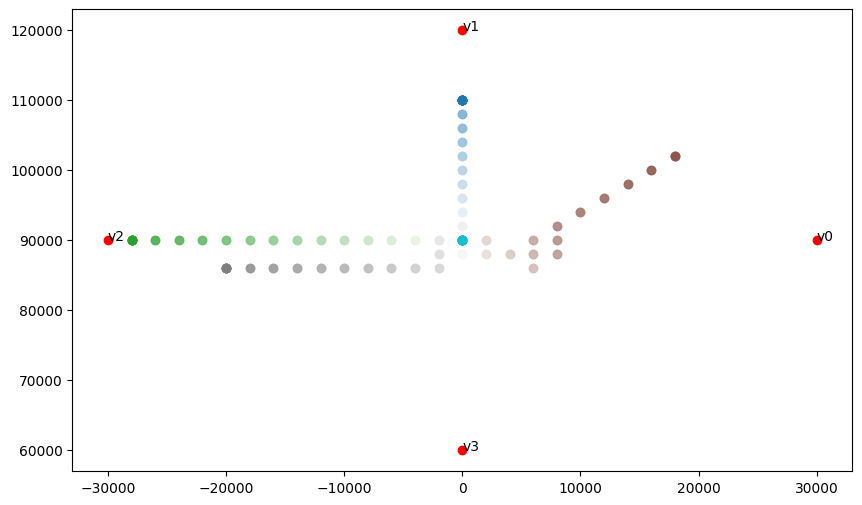

Gen 2 Policies Fitness:  [2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 5.0333065064596525
CURRENT BEST
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Sim Complete. Dense Reward Sum: 5.0333065064596525  | Global Reward: 2


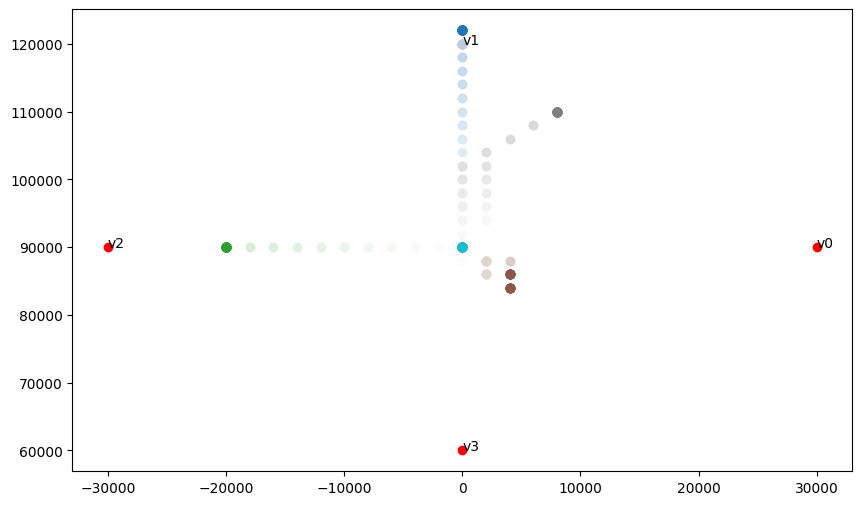

AFTER RL
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Sim Complete. Dense Reward Sum: 2.8911821235784663  | Global Reward: 1


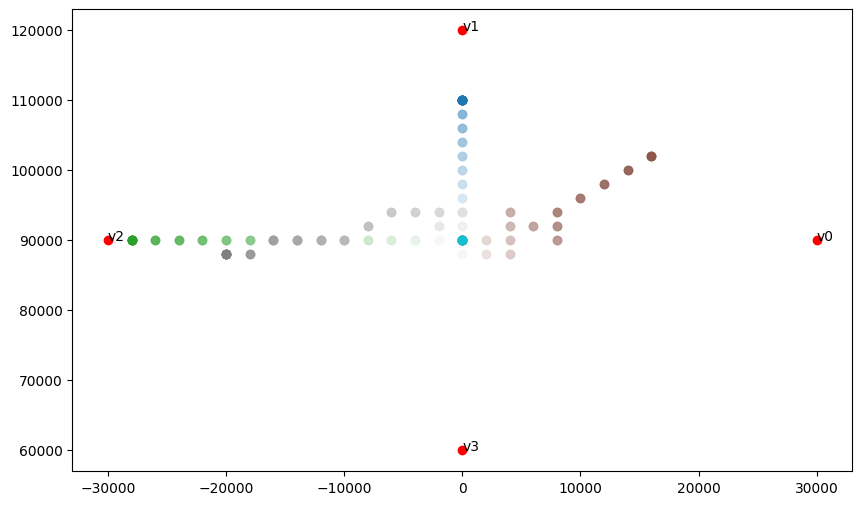

Gen 3 Policies Fitness:  [2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 5.0333065064596525
CURRENT BEST
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Sim Complete. Dense Reward Sum: 5.0333065064596525  | Global Reward: 2


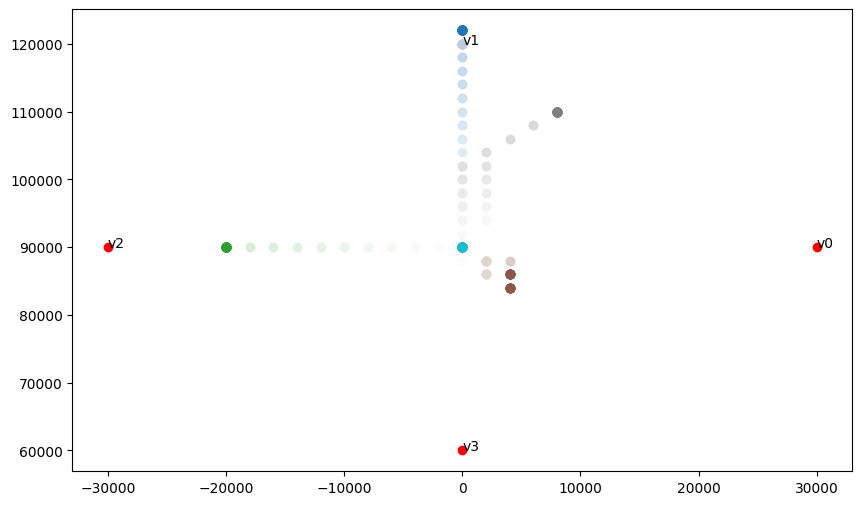

AFTER RL
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Sim Complete. Dense Reward Sum: 2.4058169085680756  | Global Reward: 1


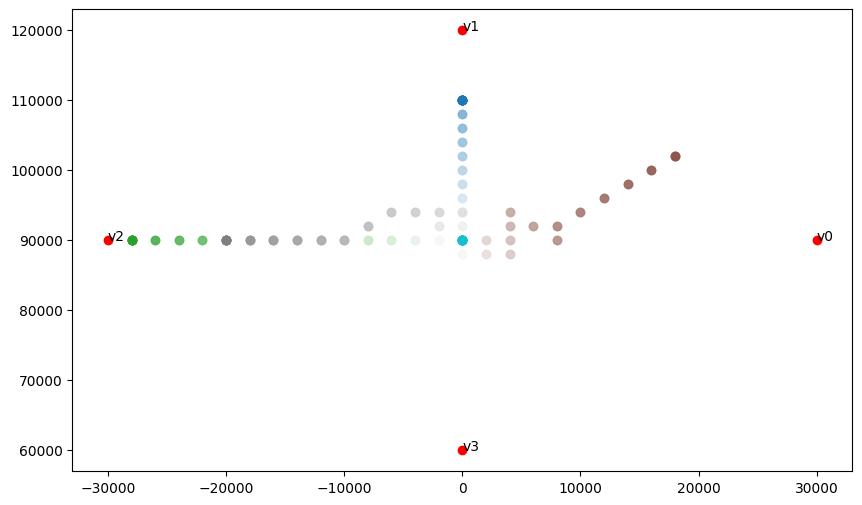

Gen 4 Policies Fitness:  [2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 5.0333065064596525
CURRENT BEST
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Sim Complete. Dense Reward Sum: 5.0333065064596525  | Global Reward: 2


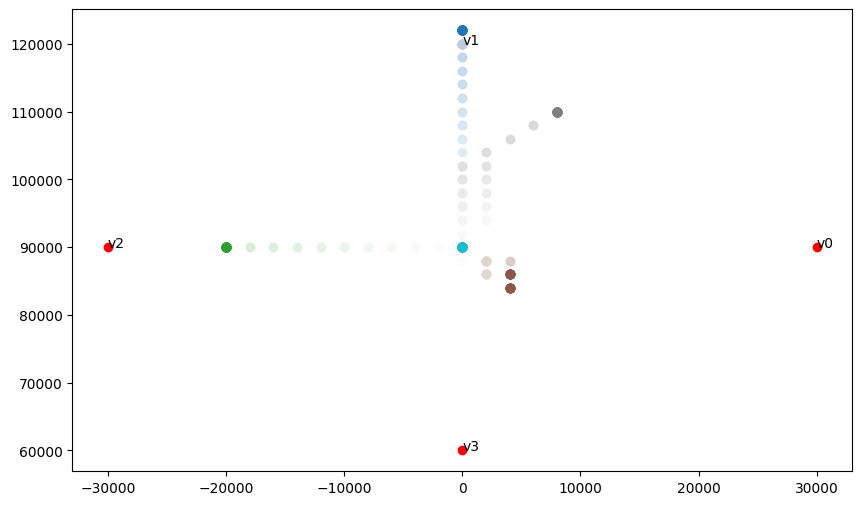

AFTER RL
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Sim Complete. Dense Reward Sum: 2.8825569955010795  | Global Reward: 1


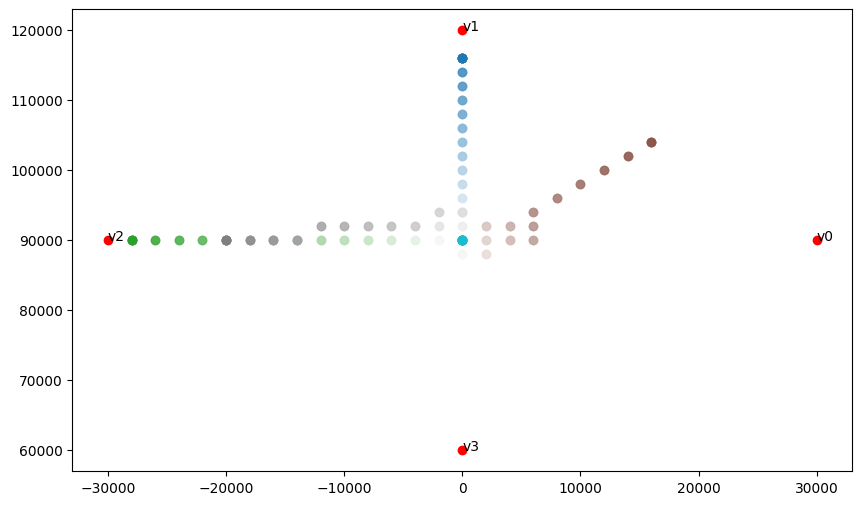

Gen 5 Policies Fitness:  [2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 5.0333065064596525
CURRENT BEST
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Sim Complete. Dense Reward Sum: 5.0333065064596525  | Global Reward: 2


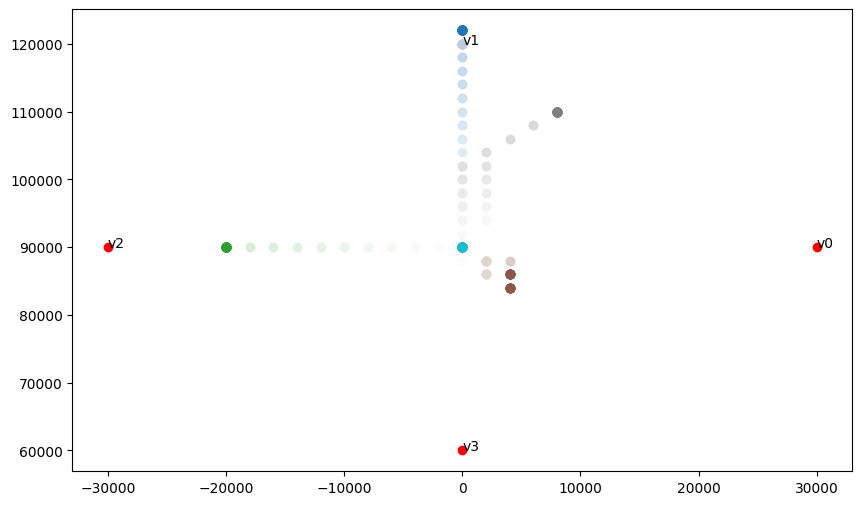

KeyboardInterrupt: 

In [ ]:
USE_EA = True
USE_RL = True

best_policy, global_rewards_over_training, average_cum_dense_rew_over_training, average_loss_over_training = train_MERL(test_config, topo_file, tide_folder, USE_EA, USE_RL)

## **Evaluate Results**

Define Plotting Functions to display running average G achieved

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    moving_avg = np.convolve(data, np.ones(window_size) / window_size, mode='valid')

    #Get square of standard deviation
    # squared_devs = np.convolve((data - moving_avg) ** 2, np.ones(window_size) / window_size, mode='valid')

    # Take the square root to get the standard deviation
    # moving_se = np.sqrt(squared_devs)/np.sqrt(window_size)

    return moving_avg#, moving_se

# TODO: Add SE plotting - need to verify this

def plot_global_reward_avg(rewards_list, window_size=50, figname="test.png"):
    fig = plt.figure()
    plt.tight_layout()

    avg_rewards = moving_average(rewards_list, window_size)
    #  min_vals, max_vals = moving_min_max(rewards_list, window_size)

    x_range = range(window_size - 1, len(rewards_list))
    plt.plot(x_range, avg_rewards)

    # Plot the band between min and max values within the window
    #  plt.fill_between(x_range, min_vals, max_vals, alpha=0.2)

    #Plot the standhard error
    # plt.errorbar(x_range, avg_rewards, yerr=s_e, capsize=5)

    # plt.title("Running Average Global Reward over Training")
    plt.ylabel("Reward")
    plt.xlabel("Epochs")
    plt.ylim(top=8)
    #  plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncols=4)
    plt.savefig(figname)
    plt.show()


In [ ]:
plot_global_reward_avg(global_rewards_over_training)

In [ ]:
plot_global_reward_avg(average_cum_dense_rew_over_training)

Visualize Policy

In [13]:
from utils.visualizer import *
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

def visualize_policy(policy: Policy,
                     test_config,
                      topo_file,
                      tide_folder
                     ):
    """Visualize policy rollout"""

    # Load testing params
    with open(test_config, "r") as f:
        config = yaml.safe_load(f)
        verbose = config["verbose"]
        timeout = config["sim_timeout"]
        comms_max_range = config["comms_max_range"]
        random_base = config["random_base"]
        base_loc = config["base_loc"]

    f.close()

    print("Initializing...")

    # === Initialize ===

    # Initialize environment
    print("\t Environment...")
    env = make_environment_from_config(test_config,
                                       topo_file,
                                       tide_folder
                                       )
    # Generate tasks & base
    env.task_dict = generate_tasks_from_config(test_config, env)
    env.setup_base_loc(random_base, base_loc)

    # Initialize agents
    print("\t Agents...")
    passenger_list = generate_passengers_from_config(test_config)
    mothership = gen_mother_from_config(test_config, passenger_list)
    mothership.agent_ids = [a.id for a in passenger_list]
    mothership.passenger_list = passenger_list
    for p in passenger_list:
        p.agent_ids = [a.id for a in passenger_list]
        p.passenger_list = passenger_list
        p.mothership_id = mothership.id

    # === Evaluate Policy (Rollout) ===

    # Reset tasks and agent locs
    if verbose: print("\t Reset Env & Agents")
    env.reset()

    # Reset agents
    mothership.reset(env)
    for p in passenger_list:
        p.reset(env)

    # Run Simulation
    done = False
    step = 0
    if verbose: print("\t Start Sim")

    # Update state
    for p in passenger_list:
        # Update observations
        p.update_state(env, comms_max_range)
    for p in passenger_list:
        p.check_neighbor_connect(env, comms_max_range)
    # Update global observation (same as local)
    mothership.update_observation(env, step)
    # Use policy to get next joint action
    state = mothership.observation[:]

    cum_dense_rew = 0
    stored_agent_locations = []

    while not done and step < timeout:
        step += 1

        joint_action_ids = policy.get_action(state)
        joint_action = policy.process_action(joint_action_ids)

        # Update environment
        # (NOTE Try out different reward shaping approaches here)
        done = env.step(joint_action, passenger_list)
        reward = compute_dense_local_reward(env, passenger_list)
        cum_dense_rew += np.average(reward)

        # Update state
        for p in passenger_list:
            # Update observations
            p.update_state(env, comms_max_range)
        for p in passenger_list:
            p.check_neighbor_connect(env, comms_max_range)
        # Update global observation (same as local)
        mothership.update_observation(env, step/timeout)
        new_state = mothership.observation[:]

        # Update state
        state = new_state

        locations = [loc for loc in env.agent_loc_dict.values()]
        if len(stored_agent_locations) < timeout:
            stored_agent_locations.append(deepcopy(locations))

    # Calculate final global reward
    final_reward = compute_global_reward(env, passenger_list)

    print("\t Sim Complete. Dense Reward Sum:", cum_dense_rew, " | Global Reward:", final_reward)

    # ==== Plot agent trajectories and task locations ===

    # Create a colormap for gradient coloring
    cmap = plt.cm.viridis  # Change to other colormaps if preferred (e.g., 'plasma', 'coolwarm')
    norm = Normalize(vmin=0, vmax=len(stored_agent_locations) - 1)

    viz = set_up_visualizer(env, env.task_dict, title="Policy Trajectory")
    viz._prepare_plot()
    viz._add_tasks_to_plot()
    # Generate unique base colors for each agent
    num_agents = len(stored_agent_locations[0])
    base_colors = plt.cm.tab10(np.linspace(0, 1, num_agents))  # Adjust colormap as needed

    # Normalize time steps for gradient mapping
    norm = Normalize(vmin=0, vmax=len(stored_agent_locations) - 1)

    for rob_id in range(num_agents):
        rob_x = []
        rob_y = []
        rob_z = []

        for t, locs in enumerate(stored_agent_locations):
            rob_loc = locs[rob_id]
            rob_x.append(rob_loc[0])
            rob_y.append(rob_loc[1])
            rob_z.append(rob_loc[2])

        # Create a monochromatic colormap for this agent
        base_color = base_colors[rob_id]
        agent_cmap = LinearSegmentedColormap.from_list(f"agent_{rob_id}_cmap", ["white", base_color])

        # Generate gradient colors based on time
        gradient_colors = agent_cmap(norm(range(len(stored_agent_locations))))

        if env.SLICE:
            # 2D case
            for i in range(1, len(rob_x)):
                viz.ax.scatter(
                    rob_x[i - 1:i + 1],
                    rob_y[i - 1:i + 1],
                    color=gradient_colors[i],
                    alpha=0.8,
                )
        else:
            # 3D case
            for i in range(1, len(rob_x)):
                viz.ax.scatter(
                    rob_x[i - 1:i + 1],
                    rob_y[i - 1:i + 1],
                    rob_z[i - 1:i + 1],
                    color=gradient_colors[i],
                    alpha=0.8,
                )
    plt.show()

In [ ]:
visualize_policy(best_policy, test_config, topo_file, tide_folder)

Code Block Graveyard

In [ ]:

def train_RL_no_head(env,
             mothership,
             passenger_list,
             pol,
             replay_buffer,
             batch_size,
             lr,
             gamma,
             epsilon,
             comms_max_range,
             timeout,
             num_agents,
             num_actions
             ):
  """
  Train network (DQN) over a batch of simulation experiences from replay buffer using RL
  """

  # Add some explorative experiences to replay buffer here (maybe 10%-25% of buffer)
  num_RL_experiences = len(replay_buffer)/5 # REPLACE 20% of buffer with RL actions (adds some exploration!)

  count = 0
  while count < num_RL_experiences:

    # Reset tasks and agent locs
    env.reset()

    # Reset agents
    mothership.reset(env)
    for p in passenger_list:
        p.reset(env)

    # Run Simulation
    done = False
    step = 0

    # !!! Startup for RL
    # Update state
    for p in passenger_list:
        # Update observations
        p.update_state(env, comms_max_range)
    for p in passenger_list:
        p.check_neighbor_connect(env, comms_max_range)

    # Update global observation (same as local)
    mothership.update_observation(env, step)
    # Use policy to get next joint action
    state = mothership.observation[:]

    while not done and step < timeout:
        step += 1

        # Get joint action
        joint_action_ids = epsilon_greedy_action(pol, state, epsilon, num_agents, num_actions)
        joint_action = pol.process_action(joint_action_ids)

        # Update environment
        done = env.step(joint_action, passenger_list)
        reward = compute_dense_local_reward(env, passenger_list)

        # Update state
        for p in passenger_list:
            # Update observations
            p.update_state(env, comms_max_range)
        for p in passenger_list:
            p.check_neighbor_connect(env, comms_max_range)
        # Update global observation (same as local)
        mothership.update_observation(env, step)
        # Use policy to get next joint action
        new_state = mothership.observation[:]

        # RL: Add observations, actions, rewards to replay buffer for RL
        replay_buffer.append((state, joint_action_ids, reward, new_state, done))
        count += 1

        # Update state
        state = new_state


  if len(replay_buffer) < batch_size:
    return

  minibatch = random.sample(replay_buffer, batch_size)

  #TODO: Need to split minibatch buffer into separate agents somehow (maybe not)
  #Lets call this new minibatch minibatch_split, not sure yet how to implement this

  #Repeat over each agent in policy - each has a separate head as far as I can tell
  optimizer = optim.Adam(pol.policy_net.parameters(), lr=lr)

  for state, action, reward, next_state, done in minibatch:
    # print("Experience: State=", state, "Action=", action, "Reward=", reward, "Next=", next_state, "Done=", done)
    state_act_vals = pol.policy_net(torch.tensor(state, dtype=torch.float32))
    # print("State Action Vals:", state_act_vals)
    next_state_act_vals = pol.policy_net(torch.tensor(next_state, dtype=torch.float32))
    # print("Next State Action Vals:", state_act_vals)


    #Init Optimizer

    for a_id,head in enumerate(pol.policy_net.heads):
      target = reward

      if not done:
        # TODO might need to change where softmax is applied for action outputs
        target = reward[a_id] + gamma * torch.max(next_state_act_vals[a_id]).item()

      # print("!!!Head", a_id, "target", target)

      target_f = deepcopy(state_act_vals[a_id].detach().numpy())
      # print("Head target_f without target:", target_f, " Head state act vals:", state_act_vals[a_id])
      target_f[action[a_id]] = target
      # print("Head target_f with target:", target_f, " Head state act vals:", state_act_vals[a_id])

      optimizer.zero_grad()
      loss = nn.MSELoss()(torch.tensor(target_f), state_act_vals[a_id])
      # print("Computed loss:", loss)
      loss.backward(retain_graph=True) # NOTE: THIS PROBABLY ISN'T GOOD TO USE HERE
      optimizer.step()

File Logging

In [14]:
import sys
import os
from datetime import datetime

class fileLogger:

  def __init__(self, filename: str=None):
    log_dir = os.path.join(sys.path[0], "logs")

    if not os.path.isdir(log_dir):
      os.mkdir(log_dir)

    if filename is None:
      filename = os.path.join(
          log_dir, f"{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.csv"
      )
    else:
      filename = os.path.join(log_dir, filename)

    self.log_filename = filename
    self.log_file = open(filename, 'w')

  def close(self):
    self.log_file.close()
    self.log_file = None


  def call(
      self,
      input_data: float
  ):
      with open(self.log_filename, 'a') as self.log_file:
        for data in input_data:
          self.log_file.write(f"{data} \n")

Initializing...
	 Environment...
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Agents...
	 Policies...
Begin Training
Gen 0 Policies Fitness:  [2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 28.160639626494053
Gen 1 Policies Fitness:  [4.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 36.78166772569348
Gen 2 Policies Fitness:  [4.0, 4.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 36.78166772569348
Gen 3 Policies Fitness:  [4.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 36.78166772

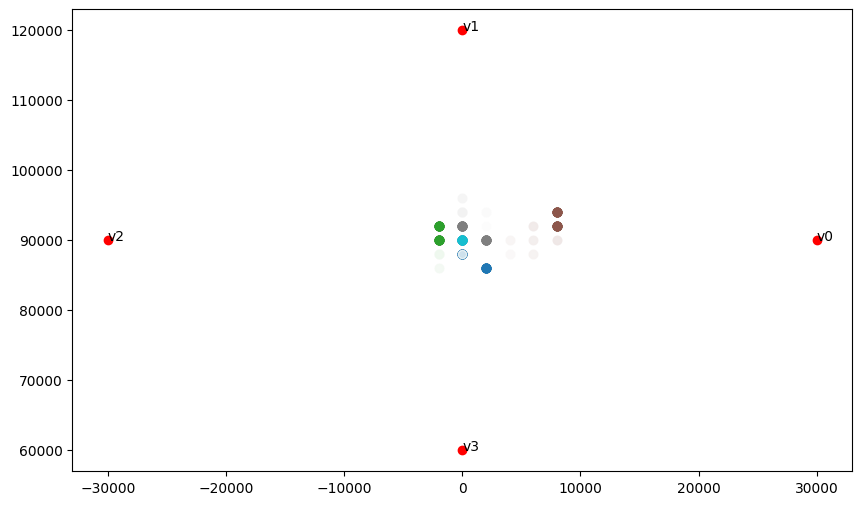

Initializing...
	 Environment...
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Agents...
	 Policies...
Begin Training
Gen 0 Policies Fitness:  [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 16.078611531198554
Gen 1 Policies Fitness:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 16.078611531198554
Gen 2 Policies Fitness:  [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 16.078611531198554
Gen 3 Policies Fitness:  [2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 18.240084

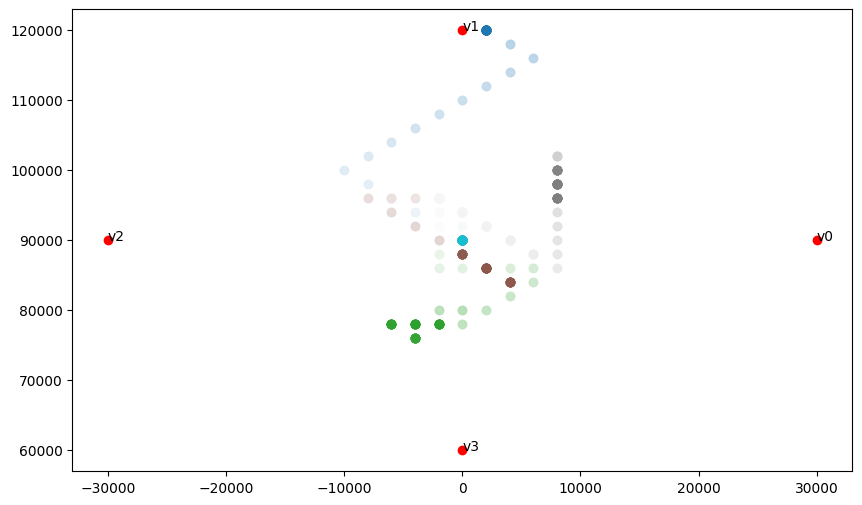

Initializing...
	 Environment...
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Agents...
	 Policies...
Begin Training
Gen 0 Policies Fitness:  [2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 20.92708829112091
Gen 1 Policies Fitness:  [3.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 31.75325529447168
Gen 2 Policies Fitness:  [3.0, 3.0, 3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 31.75325529447168
Gen 3 Policies Fitness:  [3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 31.753255294

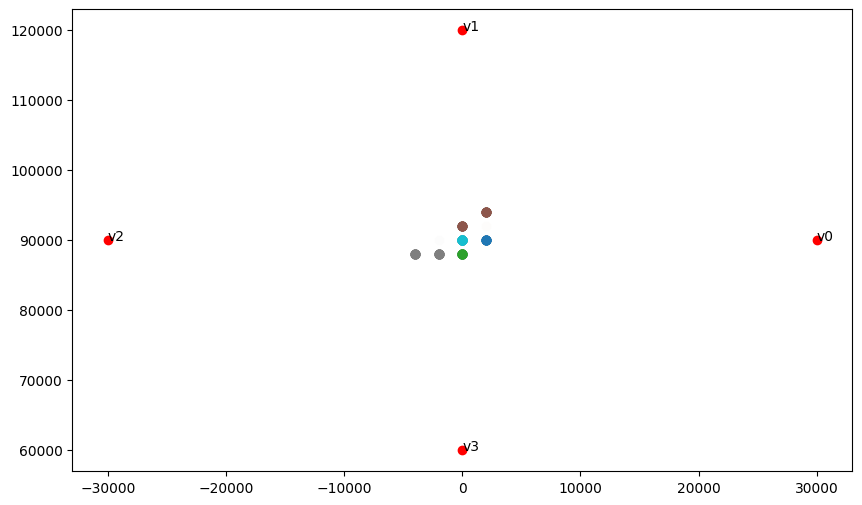

Initializing...
	 Environment...
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Agents...
	 Policies...
Begin Training
Gen 0 Policies Fitness:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 15.410707776712993
Gen 1 Policies Fitness:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 15.410707776712993
Gen 2 Policies Fitness:  [2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 21.337588175435542
Gen 3 Policies Fitness:  [2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 21.337588

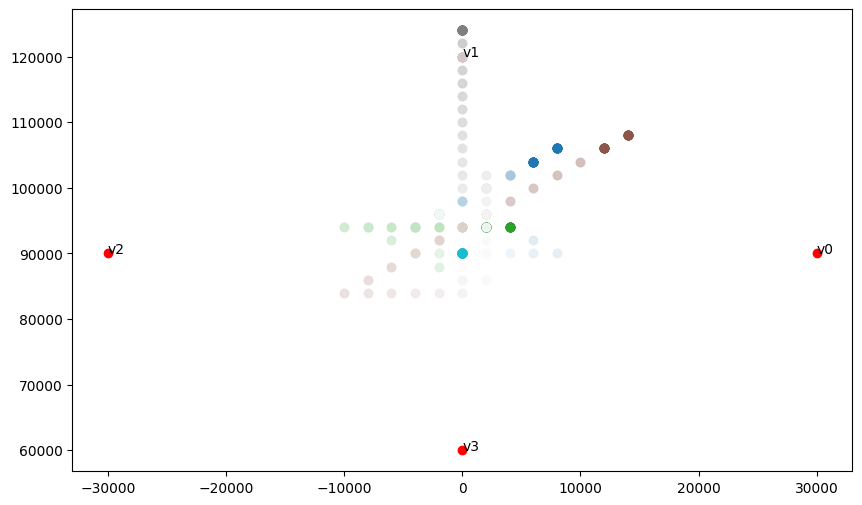

Initializing...
	 Environment...
Selected flow data file datasets/currents/StrongTides_inst_hour1.nc
	 Agents...
	 Policies...
Begin Training
Gen 0 Policies Fitness:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 15.249582626723372
Gen 1 Policies Fitness:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 15.249582626723372
Gen 2 Policies Fitness:  [2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 16.925408676403457
Gen 3 Policies Fitness:  [2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  | Best Dense Reward: 16.925408

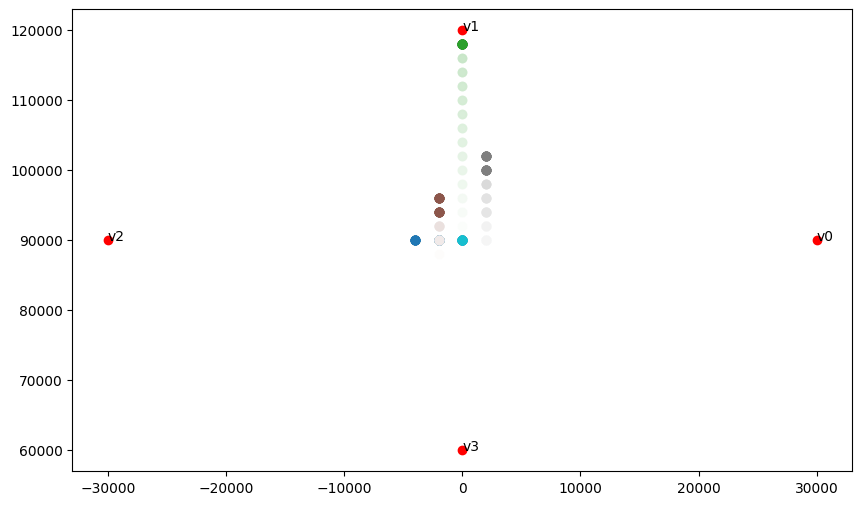

In [17]:
num_trials = 5


USE_EA = True
USE_RL = True

name_list = []

for i in range(num_trials):

  name_list.append('L2_MERL'+str(i+6)+f'.csv')
  var = fileLogger(name_list[i])
  best_policy, global_rewards_over_training, average_cum_dense_rew_over_training, average_loss_over_training = train_MERL(test_config, topo_file, tide_folder, USE_EA, USE_RL)
  visualize_policy(best_policy, test_config, topo_file, tide_folder)
  input_data = global_rewards_over_training
  var.call(input_data)
  var.close()



